# Overall Framework

**Main Modules in PSMNet**
1. Spatial Pyramid Pooling (SPP) Module
2. Stacked Hourglass

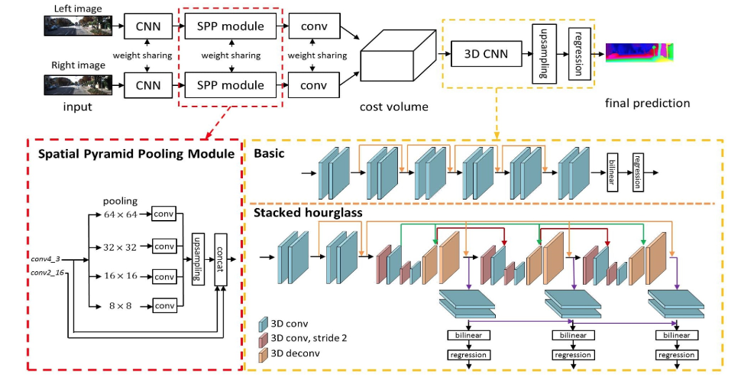


In [1]:
!git clone https://github.com/Chohoonhee/PSMNet_Colab
%cd /content/PSMNet_Colab/PSMnet/

Cloning into 'PSMNet_Colab'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 41 (delta 13), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (41/41), 1.07 MiB | 3.54 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/PSMNet_Colab/PSMnet


In [2]:
import os.path
from os import path

from google.colab import drive

drive.mount('/content/gdrive/')
datapath = '/content/gdrive/MyDrive/PSMNet/data/KITTI_2015/training/'
savemodel = './saved_model'

if path.exists(savemodel) == False:
    os.mkdir(savemodel)

Mounted at /content/gdrive/


## import module and function

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import time
from submodule import *
from preprocess import *
from dataloader import listflowfile as lt
from dataloader.KITTILoader import *
from dataloader.KITTIloader2015 import *

## Get dataset string
### Get strings such as left image, right image, and disparity in the data path.

In [5]:
all_left_img, all_right_img, all_left_disp, test_left_img, test_right_img, test_left_disp = dataloader(datapath)
print('left image string:', all_left_img[0])
print('right image string: ', all_right_img[0])
print('left disparity string: ', all_left_disp[0])
print('test left image string: ',test_left_img[0])
print('test right image string: ', test_right_img[0])

left image string: /content/gdrive/MyDrive/PSMNet/data/KITTI_2015/training/image_2/000148_10.png
right image string:  /content/gdrive/MyDrive/PSMNet/data/KITTI_2015/training/image_3/000148_10.png
left disparity string:  /content/gdrive/MyDrive/PSMNet/data/KITTI_2015/training/disp_occ_0/000148_10.png
test left image string:  /content/gdrive/MyDrive/PSMNet/data/KITTI_2015/training/image_2/000153_10.png
test right image string:  /content/gdrive/MyDrive/PSMNet/data/KITTI_2015/training/image_3/000153_10.png


## Define dataloader
### Define dataloader using image string.

In [6]:
KITTI_dataset_train = myImageFloder(all_left_img,all_right_img,all_left_disp, True)
TrainImgLoader = torch.utils.data.DataLoader(KITTI_dataset_train,
      batch_size=1, shuffle= True, num_workers= 8, drop_last=False)
print('Train object: ', TrainImgLoader)
KITTI_dataset_test = myImageFloder(test_left_img, test_right_img, test_left_disp, True)
TestImgLoader = torch.utils.data.DataLoader(KITTI_dataset_test, \
                batch_size=8, shuffle= False, num_workers= 4, drop_last=False)
print('Test object: ', TestImgLoader)

Train object:  <torch.utils.data.dataloader.DataLoader object at 0x7df71bfa33a0>
Test object:  <torch.utils.data.dataloader.DataLoader object at 0x7df62e9ad720>


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Check KITTI dataset data
### Plot the images using the KITTI dataset information we defined

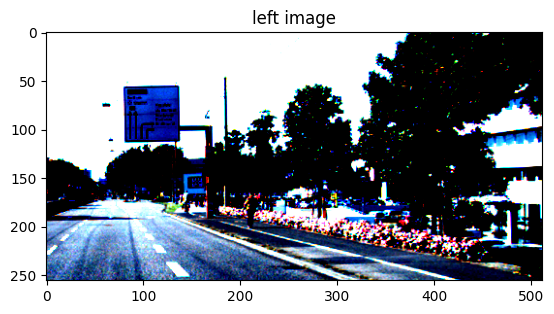

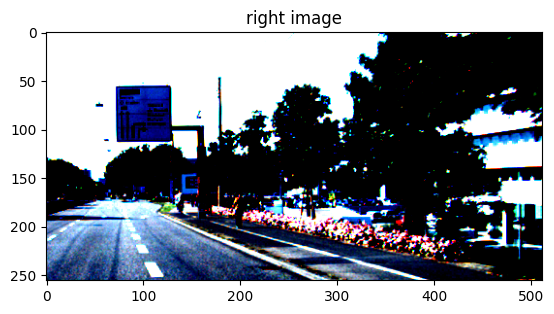

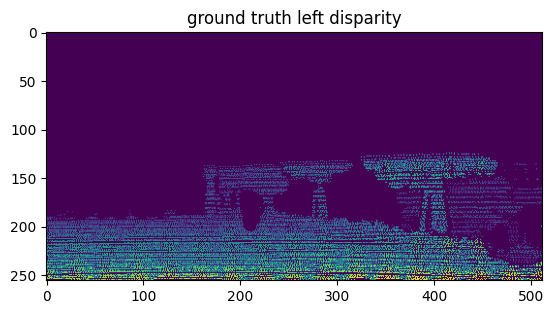

In [7]:
left_img, right_img, left_disp = KITTI_dataset_train.__getitem__(0)
plt.figure()
plt.title('left image')
plt.imshow(left_img.detach().cpu().numpy().transpose(1,2,0))
plt.figure()
plt.title('right image')
plt.imshow(right_img.detach().cpu().numpy().transpose(1,2,0))
plt.figure()
plt.title('ground truth left disparity')
plt.imshow(left_disp)

## Define feature extractor
### Let`s define a function to extract features from the image
### Among them, we will implemet the Spatial pyramid pooling module

In [8]:
def convbn(in_planes, out_planes, kernel_size, stride, pad, dilation):
    return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=dilation if dilation > 1 else pad, dilation = dilation, bias=False),
                         nn.BatchNorm2d(out_planes))

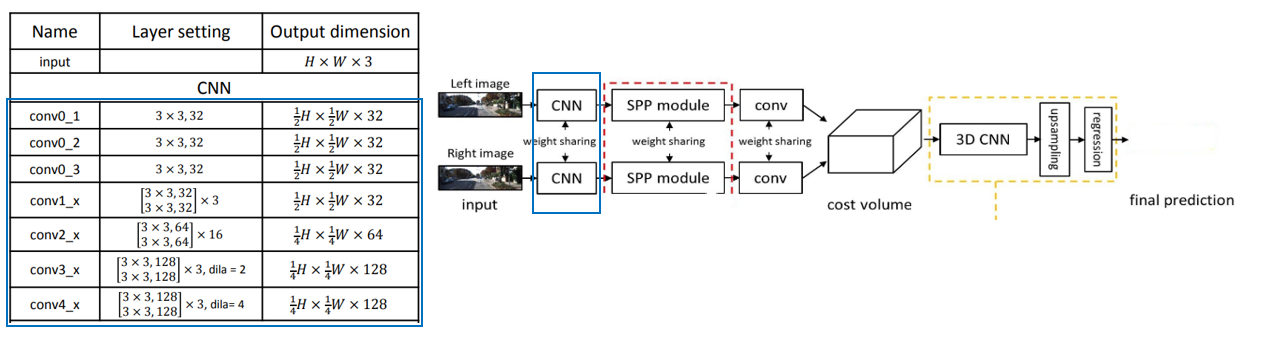

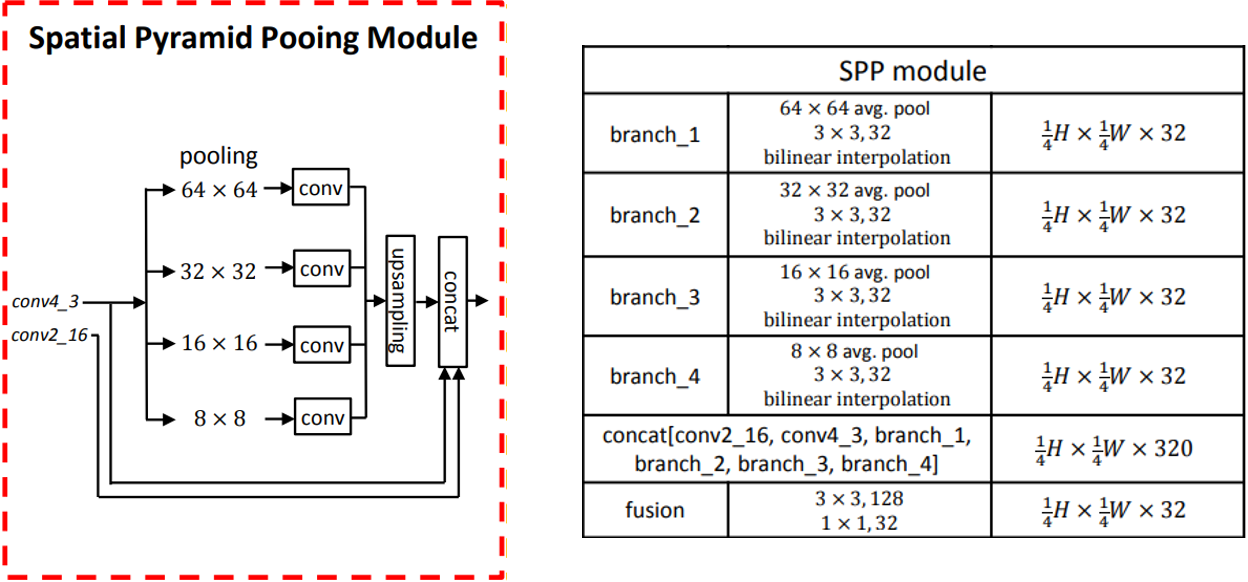

In [9]:
def convbn(in_planes, out_planes, kernel_size, stride, pad, dilation):
    return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=dilation if dilation > 1 else pad, dilation = dilation, bias=False),
                         nn.BatchNorm2d(out_planes))

class feature_extraction(nn.Module):
    def __init__(self):
        super(feature_extraction, self).__init__()
        self.inplanes = 32


        ### conv0_1, conv0_2, conv0_3
        self.firstconv = nn.Sequential(convbn(in_planes=3, out_planes=32, kernel_size=3, stride=2, pad=1, dilation=1),
                                       nn.ReLU(inplace=True),
                                       convbn(in_planes=32, out_planes=32, kernel_size=3, stride=1, pad=1, dilation=1),
                                       nn.ReLU(inplace=True),
                                       convbn(in_planes=32, out_planes=32, kernel_size=3, stride=1, pad=1, dilation=1),
                                       nn.ReLU(inplace=True))

        ### conv1_x
        self.layer1 = self._make_layer(block=BasicBlock, planes=32, blocks=3, stride=1, pad=1, dilation=1)

        ### conv2_x
        self.layer2 = self._make_layer(block=BasicBlock, planes=64, blocks=16, stride=2, pad=1, dilation=1)

        ### conv3_x
        self.layer3 = self._make_layer(block=BasicBlock, planes=128, blocks=3, stride=1, pad=1, dilation=1)

        ### conv4_x
        self.layer4 = self._make_layer(block=BasicBlock, planes=128, blocks=3, stride=1, pad=1, dilation=2)

        ### SPP module
        self.branch1 = nn.Sequential(nn.AvgPool2d((64, 64), stride=(64,64)),
                                     convbn(in_planes=128, out_planes=32, kernel_size=1, stride=1, pad=0, dilation=1),
                                     nn.ReLU(inplace=True))

        self.branch2 = nn.Sequential(nn.AvgPool2d((32, 32), stride=(32,32)),
                                     convbn(in_planes=128, out_planes=32, kernel_size=1, stride=1, pad=0, dilation=1),
                                     nn.ReLU(inplace=True))

        self.branch3 = nn.Sequential(nn.AvgPool2d((16, 16), stride=(16,16)),
                                     convbn(in_planes=128, out_planes=32, kernel_size=1, stride=1, pad=0, dilation=1),
                                     nn.ReLU(inplace=True))

        self.branch4 = nn.Sequential(nn.AvgPool2d((8, 8), stride=(8,8)),
                                     convbn(in_planes=128, out_planes=32, kernel_size=1, stride=1, pad=0, dilation=1),
                                     nn.ReLU(inplace=True))


        self.lastconv = nn.Sequential(convbn(320, 128, 3, 1, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, kernel_size=1, padding=0, stride = 1, bias=False))

    def _make_layer(self, block, planes, blocks, stride, pad, dilation):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
           downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, pad, dilation))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,1,None,pad,dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        output      = self.firstconv(x)
        output      = self.layer1(output)
        output_raw  = self.layer2(output)
        output      = self.layer3(output_raw)
        output_skip = self.layer4(output)


        output_branch1 = self.branch1(output_skip)
        output_branch1 = F.upsample(output_branch1, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch2 = self.branch2(output_skip)
        output_branch2 = F.upsample(output_branch2, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch3 = self.branch3(output_skip)
        output_branch3 = F.upsample(output_branch3, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch4 = self.branch4(output_skip)
        output_branch4 = F.upsample(output_branch4, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_feature = torch.cat((output_raw, output_skip, output_branch4, output_branch3, output_branch2, output_branch1), 1)
        output_feature = self.lastconv(output_feature)

        return output_feature

## Define hourglass module
### Let`s define hourglass module using 3d convolution and batchnormalization3D
### Please refer to convbn_3d function

In [10]:
def convbn_3d(in_planes, out_planes, kernel_size, stride, pad):
    return nn.Sequential(nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, padding=pad, stride=stride,bias=False),
                         nn.BatchNorm3d(out_planes))

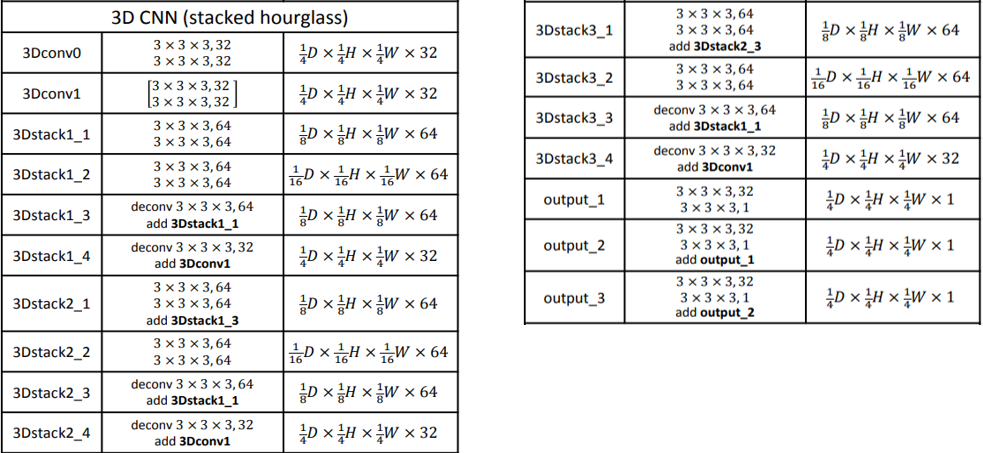

In [11]:
class hourglass(nn.Module):
    def __init__(self, inplanes=32):
        super(hourglass, self).__init__()

        ### 3DstackX_1
        self.conv1 = nn.Sequential(convbn_3d(inplanes, inplanes*2, kernel_size=3, stride=2, pad=1),
                                   nn.ReLU(inplace=True))
        self.conv2 = convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=1, pad=1)


        ### 3DstackX_2
        self.conv3 = nn.Sequential(convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=2, pad=1),
                                   nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=1, pad=1),
                                   nn.ReLU(inplace=True))

        ### 3DstackX_3
        self.conv5 = nn.Sequential(nn.ConvTranspose3d(inplanes*2, inplanes*2, kernel_size=3, padding=1, output_padding=1, stride=2,bias=False),
                                   nn.BatchNorm3d(inplanes*2))

        ### 3DstackX_4
        self.conv6 =  nn.Sequential(nn.ConvTranspose3d(inplanes*2, inplanes, kernel_size=3, padding=1, output_padding=1, stride=2,bias=False),
                                   nn.BatchNorm3d(inplanes))


    def forward(self, x, presqu, postsqu):

        out  = self.conv1(x) #in:1/4 out:1/8
        pre  = self.conv2(out) #in:1/8 out:1/8
        if postsqu is not None:
           pre = F.relu(pre + postsqu, inplace=True)
        else:
           pre = F.relu(pre, inplace=True)

        out  = self.conv3(pre) #in:1/8 out:1/16
        out  = self.conv4(out) #in:1/16 out:1/16

        if presqu is not None:
           post = F.relu(self.conv5(out)+presqu, inplace=True) #in:1/16 out:1/8
        else:
           post = F.relu(self.conv5(out)+pre, inplace=True)

        out  = self.conv6(post)  #in:1/8 out:1/4
        return out, pre, post

## PSMnet
### Define PSMnet
#### Step1: Define feature extraction part
#### Step2: Defien 3D convolution part
#### Step3: weight initialization
### PSMnet forward
#### Step1: In left, right image, feature extraction is performed
#### Step2: make cost volume.
#### Step3: cost volume refinement using 3D CNN.
#### Step4: perform disparity regression.

In [12]:
class PSMNet(nn.Module):
    def __init__(self, maxdisp):
        super(PSMNet, self).__init__()
        self.maxdisp = maxdisp
        # step1 - feature extractor
        self.feature_extraction = feature_extraction()
        # step2 - 3D convolution part
        self.dres0 = nn.Sequential(convbn_3d(in_planes=64, out_planes=32, kernel_size=3, stride=1, pad=1),
                                     nn.ReLU(inplace=True),
                                     convbn_3d(in_planes=32, out_planes=32, kernel_size=3, stride=1, pad=1),
                                     nn.ReLU(inplace=True))

        self.dres1 = nn.Sequential(convbn_3d(in_planes=32, out_planes=32, kernel_size=3, stride=1, pad=1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(in_planes=32, out_planes=32, kernel_size=3, stride=1, pad=1))

        self.dres2 = hourglass(32)
        self.dres3 = hourglass(32)
        self.dres4 = hourglass(32)

        self.classif1 = nn.Sequential(convbn_3d(in_planes=32, out_planes=32, kernel_size=3, stride=1, pad=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        self.classif2 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        self.classif3 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        # Step3 - weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()


    def forward(self, left, right):
        # Step 1 - feature extraction
        refimg_fea     = self.feature_extraction(left)
        targetimg_fea  = self.feature_extraction(right)


        # Step 2: make cost volume.
        cost = Variable(torch.FloatTensor(refimg_fea.size()[0], refimg_fea.size()[1]*2, self.maxdisp//4,  refimg_fea.size()[2],  refimg_fea.size()[3]).zero_()).cuda()

        for i in range(self.maxdisp//4):
            if i > 0 :
             cost[:, :refimg_fea.size()[1], i, :,i:]   = refimg_fea[:,:,:,i:]
             cost[:, refimg_fea.size()[1]:, i, :,i:] = targetimg_fea[:,:,:,:-i]
            else:
             cost[:, :refimg_fea.size()[1], i, :,:]   = refimg_fea
             cost[:, refimg_fea.size()[1]:, i, :,:]   = targetimg_fea
        cost = cost.contiguous()
        # Step 3: Perform 3D convolution.
        cost0 = self.dres0(cost)
        cost0 = self.dres1(cost0) + cost0

        out1, pre1, post1 = self.dres2(cost0, None, None)
        out1 = out1+cost0

        out2, pre2, post2 = self.dres3(out1, pre1, post1)
        out2 = out2+cost0

        out3, pre3, post3 = self.dres4(out2, pre1, post2)
        out3 = out3+cost0

        cost1 = self.classif1(out1)
        cost2 = self.classif2(out2) + cost1
        cost3 = self.classif3(out3) + cost2
        if self.training:
          cost1 = F.upsample(cost1, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
          cost2 = F.upsample(cost2, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')

          cost1 = torch.squeeze(cost1,1)
          pred1 = F.softmax(cost1,dim=1)
          pred1 = disparityregression(self.maxdisp)(pred1)

          cost2 = torch.squeeze(cost2,1)
          pred2 = F.softmax(cost2,dim=1)
          pred2 = disparityregression(self.maxdisp)(pred2)

        cost3 = F.upsample(cost3, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
        cost3 = torch.squeeze(cost3,1)
        pred3 = F.softmax(cost3,dim=1)
        # Step 4: disparity regression.
        pred3 = disparityregression(self.maxdisp)(pred3)

        if self.training:
            return pred1, pred2, pred3
        else:
            return pred3

## main function
### Specify various hyperparmeters and dataset paths.
### Define model.
### Defien optimizer.
### print model we can see all details of module.

In [13]:
if __name__=='__main__':
    max_disp = 192
    epochs = 20
    model = PSMNet(max_disp)
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.9)
    print(model.feature_extraction)

feature_extraction(
  (firstconv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU(inplace=True)
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU(inplace=True)
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1,

## Training with KITTI dataset
### Perform training during 1 epoch.
### As the loss function, smoothness L1 loss is used
### see training log and the training loss normally decreases.

In [14]:
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5

    for epoch in range(0, epochs):
        total_train_loss = 0
        print('This is %d-th epoch' %(epoch))
        model.train()
        #import pdb
        #------------- Train ------------------------------------------------------------
        for batch_idx, (imgL_crop, imgR_crop, disp_crop_L) in enumerate(TrainImgLoader):
            # pdb.set_trace()
            optimizer.zero_grad()
            imgL_crop, imgR_crop, disp_crop_L = imgL_crop.cuda(), imgR_crop.cuda(), disp_crop_L.cuda()
            mask = (disp_crop_L < max_disp) # & (0 < disp_crop_L)
            mask.detach_()
            start_time = time.time()
            output = model(imgL_crop, imgR_crop)
            loss = 0.2 * F.smooth_l1_loss(output[0][mask], disp_crop_L[mask], size_average=True) + 0.3 * F.smooth_l1_loss(output[1][mask], disp_crop_L[mask], size_average=True) + 0.5 * F.smooth_l1_loss(output[2][mask], disp_crop_L[mask], size_average=True)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            if batch_idx % 3 == 0:
                print('Iter %d training loss = %.3f , time = %.2f' %(batch_idx, loss, time.time() - start_time))
        print('epoch %d total training loss = %.3f' %(epoch, total_train_loss/len(TrainImgLoader)))
        #SAVE
        savefilename = savemodel+'/checkpoint_'+str(epoch)+'.tar'
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'train_loss': total_train_loss/len(TrainImgLoader),
         }, savefilename)
        #------------- TEST ------------------------------------------------------------
        total_test_loss = 0
        model.eval()
        for batch_idx, (imgL, imgR, disp_L) in enumerate(TestImgLoader):
            test_loss, disp = test(model, imgL, imgR, disp_L)

            print('Iter %d test loss = %.3f' %(batch_idx, test_loss))
            total_test_loss += test_loss
        print('total test loss = %.3f' %(total_test_loss/len(TestImgLoader)))

        # Early stopping logic
        if total_test_loss < best_val_loss:
            best_val_loss = total_test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break


This is 0-th epoch


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Iter 0 training loss = 84.304 , time = 4.78
Iter 3 training loss = 8.236 , time = 0.84
Iter 6 training loss = 11.108 , time = 0.74
Iter 9 training loss = 8.089 , time = 0.82
Iter 12 training loss = 6.820 , time = 0.71
Iter 15 training loss = 2.281 , time = 0.71
Iter 18 training loss = 5.451 , time = 0.76
Iter 21 training loss = 8.260 , time = 0.73
Iter 24 training loss = 7.733 , time = 0.73
Iter 27 training loss = 6.852 , time = 0.73
Iter 30 training loss = 3.125 , time = 0.72
Iter 33 training loss = 6.501 , time = 0.72
Iter 36 training loss = 8.504 , time = 0.75
Iter 39 training loss = 3.587 , time = 0.77
Iter 42 training loss = 6.427 , time = 0.72
Iter 45 training loss = 5.181 , time = 0.73
Iter 48 training loss = 3.330 , time = 0.74
Iter 51 training loss = 6.136 , time = 0.74
Iter 54 training loss = 12.598 , time = 0.77
Iter 57 training loss = 3.816 , time = 0.76
Iter 60 training loss = 4.135 , time = 0.72
Iter 63 training loss = 2.226 , time = 0.73
Iter 66 training loss = 8.295 , t

## Test with KITTI test sample
### Let`s print the disparity image using data from the test set.
### Because training takes a long time, we use a pretrained model.

In [15]:
left_image_path = '/content/gdrive/My Drive/PSMNet/data/KITTI_2015/testing/left.png'
right_image_path = '/content/gdrive/My Drive/PSMNet/data/KITTI_2015/testing/right.png'

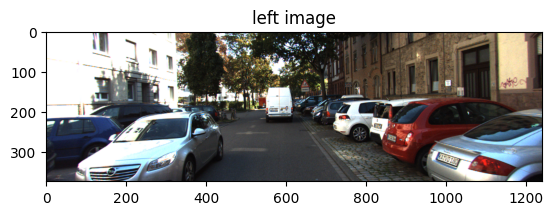

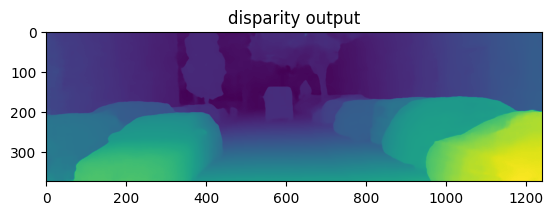

time = 1.65


In [19]:
  def test_img(imgL,imgR):
      model.eval()

      imgL = imgL.cuda()
      imgR = imgR.cuda()

      with torch.no_grad():
          disp = model(imgL,imgR)

      disp = torch.squeeze(disp)
      pred_disp = disp.data.cpu().numpy()

      return pred_disp
if __name__=='__main__':
    from collections import OrderedDict

    checkpoint = torch.load('/content/gdrive/My Drive/PSMNet/data/pretrained_model_KITTI2015.tar') #checkpoint change
    new_state_dict = OrderedDict()
    for k, v in checkpoint['state_dict'].items():
        name = k[7:]
        #name = k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    normal_mean_var = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}
    infer_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize(**normal_mean_var)])

    imgL_o = Image.open(left_image_path).convert('RGB')
    imgR_o = Image.open(right_image_path).convert('RGB')

    imgL = infer_transform(imgL_o)
    imgR = infer_transform(imgR_o)

    # pad to width and hight to 16 times
    if imgL.shape[1] % 16 != 0:
        times = imgL.shape[1]//16
        top_pad = (times+1)*16 -imgL.shape[1]
    else:
        top_pad = 0

    if imgL.shape[2] % 16 != 0:
        times = imgL.shape[2]//16
        right_pad = (times+1)*16-imgL.shape[2]
    else:
        right_pad = 0

    imgL = F.pad(imgL,(0,right_pad, top_pad,0)).unsqueeze(0)
    imgR = F.pad(imgR,(0,right_pad, top_pad,0)).unsqueeze(0)

    start_time = time.time()
    pred_disp = test_img(imgL,imgR)
    if top_pad !=0 or right_pad != 0:
      img = pred_disp[top_pad:,:-right_pad]
    else:
      img = pred_disp
    plt.figure()
    plt.title('left image')
    plt.imshow(imgL_o)
    plt.figure()
    plt.title('disparity output')
    plt.imshow(img)
    plt.show()
    print('time = %.2f' %(time.time() - start_time))